In [187]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [188]:
df = pd.read_csv("../data/raw/blogtext.csv")
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait unti..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewes van der Laag urlLink mail Ruiyu Xie ...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde: MAAK JE EIGEN WATERSTOFBOM How to build an H-...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now...


In [189]:
print(df.shape)

(681284, 7)


In [190]:
df = df.sample(n=50000, random_state=42)

In [191]:
print(df.columns) # for columns
print(df.index) # for row indexes

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')
Index([240436,  54139, 637911,  61178, 314089, 431770,  84367, 613616, 124318,
       117528,
       ...
       674487, 327719, 226534, 556017, 414786, 489324, 373999, 562002,  80072,
       389094],
      dtype='int64', length=50000)


In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 240436 to 389094
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  int64 
 1   gender  50000 non-null  object
 2   age     50000 non-null  int64 
 3   topic   50000 non-null  object
 4   sign    50000 non-null  object
 5   date    50000 non-null  object
 6   text    50000 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.1+ MB


In [193]:
df.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

In [194]:
# Creating a new dataframe with two columns
df = df[["topic", "text"]]

In [195]:
pd.set_option("display.max_colwidth", 100)
df.head()

,topic,text
240436,indUnk,1 Corinthians 5:11 'But now I have written to you not to keep company with anyone named ...
54139,Arts,"Having moved to Jersey City nearly a month ago, I had no idea that I would be packing up ..."
637911,indUnk,"urlLink Hey, Metro! Need To Save Money? Take a Hike. And this comes on the heels..."
61178,indUnk,The most hilarious movie I have seen this year.. a comedy movie with absolutely no ...
314089,Technology,Short of being attached to the bumper of a pickup truck by a cock ring and being d...


In [196]:
# Checking how many unique topics are there
pd.DataFrame(df.topic.unique()).values

array([['indUnk'],
       ['Arts'],
       ['Technology'],
       ['Education'],
       ['Student'],
       ['LawEnforcement-Security'],
       ['Law'],
       ['Manufacturing'],
       ['Marketing'],
       ['Non-Profit'],
       ['Communications-Media'],
       ['Engineering'],
       ['Internet'],
       ['Publishing'],
       ['Science'],
       ['Religion'],
       ['Museums-Libraries'],
       ['Biotech'],
       ['HumanResources'],
       ['Sports-Recreation'],
       ['Banking'],
       ['Tourism'],
       ['Advertising'],
       ['BusinessServices'],
       ['Accounting'],
       ['Military'],
       ['Chemicals'],
       ['Agriculture'],
       ['InvestmentBanking'],
       ['Transportation'],
       ['Government'],
       ['Fashion'],
       ['Architecture'],
       ['Consulting'],
       ['Telecommunications'],
       ['RealEstate'],
       ['Maritime'],
       ['Environment'],
       ['Construction'],
       ['Automotive']], dtype=object)

In [197]:
df["topic"].value_counts().nlargest(10)

topic
indUnk                  18419
Student                 11519
Technology               2985
Arts                     2339
Education                2219
Communications-Media     1458
Internet                 1197
Non-Profit               1027
Engineering               855
Law                       684
Name: count, dtype: int64

In [198]:
df["topic_id"] = df["topic"].factorize()[0]

topic_id_df = df[["topic", "topic_id"]].drop_duplicates().sort_values("topic_id")

topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[["topic_id", "topic"]].values)

In [199]:
df.head()

,topic,text,topic_id
240436,indUnk,1 Corinthians 5:11 'But now I have written to you not to keep company with anyone named ...,0
54139,Arts,"Having moved to Jersey City nearly a month ago, I had no idea that I would be packing up ...",1
637911,indUnk,"urlLink Hey, Metro! Need To Save Money? Take a Hike. And this comes on the heels...",0
61178,indUnk,The most hilarious movie I have seen this year.. a comedy movie with absolutely no ...,0
314089,Technology,Short of being attached to the bumper of a pickup truck by a cock ring and being d...,2


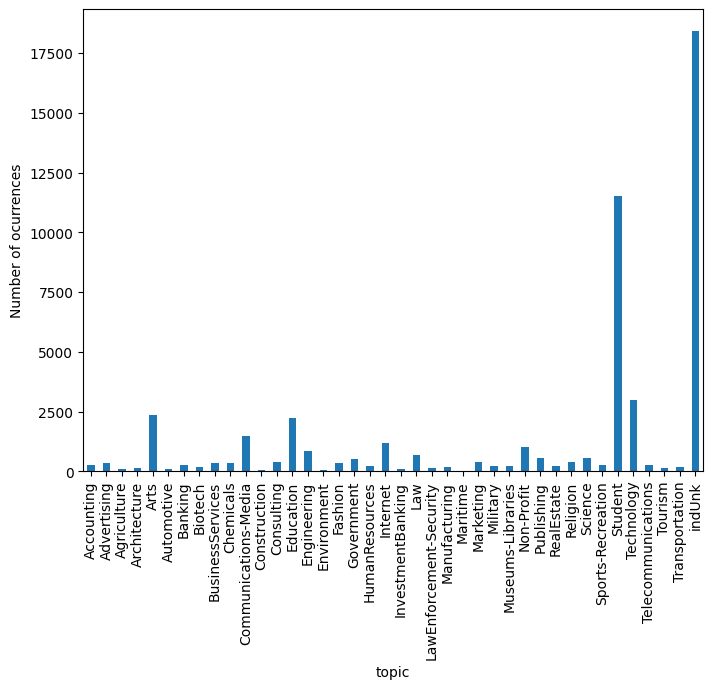

In [200]:
# Visualize the data

fig = plt.figure(figsize=(8,6))
df.groupby('topic').text.count().plot.bar(ylim=0)
plt.ylabel("Number of ocurrences", fontsize = 10);
plt.show()

In [201]:
# Pre-processing the "text" column
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [202]:
# removing punctuation

def remove_punctuation(text):
    text = "".join([c for c in text if c not in string.punctuation])
    return text

df["text"] = df["text"].apply(lambda x: remove_punctuation(x))
df.head(2)

,topic,text,topic_id
240436,indUnk,1 Corinthians 511 But now I have written to you not to keep company with anyone named a ...,0
54139,Arts,Having moved to Jersey City nearly a month ago I had no idea that I would be packing up t...,1


In [203]:
# removing unwanted characters
df["text"] = df["text"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', " ", x))
df.head()

,topic,text,topic_id
240436,indUnk,1 Corinthians 511 But now I have written to you not to keep company with anyone named a ...,0
54139,Arts,Having moved to Jersey City nearly a month ago I had no idea that I would be packing up t...,1
637911,indUnk,urlLink Hey Metro Need To Save Money Take a Hike And this comes on the heels of ...,0
61178,indUnk,The most hilarious movie I have seen this year a comedy movie with absolutely no tr...,0
314089,Technology,Short of being attached to the bumper of a pickup truck by a cock ring and being d...,2


In [204]:
# removing whitespaces (begining and trailing spaces)
df["text"] = df["text"].apply(lambda x: x.strip())
df.head()

,topic,text,topic_id
240436,indUnk,1 Corinthians 511 But now I have written to you not to keep company with anyone named a brother ...,0
54139,Arts,Having moved to Jersey City nearly a month ago I had no idea that I would be packing up to camp ...,1
637911,indUnk,urlLink Hey Metro Need To Save Money Take a Hike And this comes on the heels of the second far...,0
61178,indUnk,The most hilarious movie I have seen this year a comedy movie with absolutely no trace of slapst...,0
314089,Technology,Short of being attached to the bumper of a pickup truck by a cock ring and being dragged around ...,2


In [205]:
# replacing more than 1 spaces with single space
df["text"] = df["text"].str.replace(r"\s\s+", " ")
df.head()

,topic,text,topic_id
240436,indUnk,1 Corinthians 511 But now I have written to you not to keep company with anyone named a brother ...,0
54139,Arts,Having moved to Jersey City nearly a month ago I had no idea that I would be packing up to camp ...,1
637911,indUnk,urlLink Hey Metro Need To Save Money Take a Hike And this comes on the heels of the second far...,0
61178,indUnk,The most hilarious movie I have seen this year a comedy movie with absolutely no trace of slapst...,0
314089,Technology,Short of being attached to the bumper of a pickup truck by a cock ring and being dragged around ...,2


In [206]:
# tokenization
def tokenize(text):
    tokens = re.split("\W+", text)
    return tokens

df["text"] = df["text"].apply(lambda x: tokenize(x.lower()))
df.head()

,topic,text,topic_id
240436,indUnk,"[1, corinthians, 511, but, now, i, have, written, to, you, not, to, keep, company, with, anyone,...",0
54139,Arts,"[having, moved, to, jersey, city, nearly, a, month, ago, i, had, no, idea, that, i, would, be, p...",1
637911,indUnk,"[urllink, hey, metro, need, to, save, money, take, a, hike, and, this, comes, on, the, heels, of...",0
61178,indUnk,"[the, most, hilarious, movie, i, have, seen, this, year, a, comedy, movie, with, absolutely, no,...",0
314089,Technology,"[short, of, being, attached, to, the, bumper, of, a, pickup, truck, by, a, cock, ring, and, bein...",2


In [207]:
# removing stopwords

stopwords = nltk.corpus.stopwords.words("english")
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [208]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

df["text"] = df["text"].apply(lambda x: remove_stopwords(x))
df.head()

,topic,text,topic_id
240436,indUnk,"[1, corinthians, 511, written, keep, company, anyone, named, brother, sexually, immoral, covetou...",0
54139,Arts,"[moved, jersey, city, nearly, month, ago, idea, would, packing, camp, original, homeland, philip...",1
637911,indUnk,"[urllink, hey, metro, need, save, money, take, hike, comes, heels, second, fare, hike, two, year...",0
61178,indUnk,"[hilarious, movie, seen, year, comedy, movie, absolutely, trace, slapstick, last, time, hollywoo...",0
314089,Technology,"[short, attached, bumper, pickup, truck, cock, ring, dragged, around, great, state, texas, cant,...",2


In [209]:
# lemmatization

wn = nltk.WordNetLemmatizer()

def lemmatization(text):
    text = [wn.lemmatize(word) for word in text]
    return " ".join(text)

df["text"] = df["text"].apply(lambda x: lemmatization(x))
df.head()

,topic,text,topic_id
240436,indUnk,1 corinthian 511 written keep company anyone named brother sexually immoral covetous idolater re...,0
54139,Arts,moved jersey city nearly month ago idea would packing camp original homeland philippine well per...,1
637911,indUnk,urllink hey metro need save money take hike come heel second fare hike two year make parking att...,0
61178,indUnk,hilarious movie seen year comedy movie absolutely trace slapstick last time hollywood came pure ...,0
314089,Technology,short attached bumper pickup truck cock ring dragged around great state texas cant think anythin...,2


In [210]:
# Further Text processing using TF-IDF

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.05, max_df=0.6, ngram_range=(1,2), stop_words="english")

# Transforming each text into a vector
features = tfidf.fit_transform(df.text).toarray()
labels = df.topic_id
print(features.shape)

(50000, 182)


In [211]:
tfidf.vocabulary_

{'person': 108,
 'right': 123,
 'wrong': 176,
 'life': 79,
 'hard': 54,
 'thing': 144,
 'need': 99,
 'time': 148,
 'family': 33,
 'dont': 27,
 'know': 74,
 'probably': 115,
 'people': 107,
 'like': 80,
 'going': 45,
 'dont know': 28,
 'month': 96,
 'idea': 65,
 'away': 3,
 'new': 100,
 'wait': 160,
 'thats': 143,
 'im': 67,
 'called': 12,
 'year': 178,
 'use': 158,
 'make': 88,
 'little': 81,
 'day': 22,
 'finally': 37,
 'started': 135,
 'face': 31,
 'kid': 72,
 'ask': 2,
 'used': 159,
 'class': 17,
 'fact': 32,
 'school': 128,
 'able': 0,
 'ok': 104,
 'looking': 85,
 'took': 153,
 'seen': 130,
 'wasnt': 163,
 'got': 48,
 'book': 11,
 'change': 16,
 'look': 84,
 'morning': 97,
 'didnt': 24,
 'believe': 5,
 'tell': 142,
 'think': 145,
 'feel': 35,
 'home': 60,
 'urllink': 157,
 'come': 18,
 'second': 129,
 'movie': 98,
 'came': 13,
 'job': 71,
 'turn': 156,
 'mean': 92,
 'really': 120,
 'love': 87,
 'help': 59,
 'song': 132,
 'end': 29,
 'want': 161,
 'watch': 164,
 'game': 41,
 'man': 

In [212]:
# Finding the two most correlated terms with each of the sign categories
N = 3
for topic, topic_id in sorted(topic_to_id.items()):
    features_chi2 = chi2(features, labels == topic_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
    bigrams = [v for v in feature_names if len(v.split(" ")) == 2]
    print("n-----> %s:" %(topic))
    print("  * Most Correlated Unigrams are: %s" %(", ".join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(", ".join(bigrams[-N:])))

n-----> Accounting:
  * Most Correlated Unigrams are: home, morning, hope
  * Most Correlated Bigrams are: im going, dont know
n-----> Advertising:
  * Most Correlated Unigrams are: work, told, job
  * Most Correlated Bigrams are: dont know, im going
n-----> Agriculture:
  * Most Correlated Unigrams are: post, know, write
  * Most Correlated Bigrams are: dont know, im going
n-----> Architecture:
  * Most Correlated Unigrams are: want, minute, urllink
  * Most Correlated Bigrams are: dont know, im going
n-----> Arts:
  * Most Correlated Unigrams are: night, school, urllink
  * Most Correlated Bigrams are: im going, dont know
n-----> Automotive:
  * Most Correlated Unigrams are: ok, idea, urllink
  * Most Correlated Bigrams are: dont know, im going
n-----> Banking:
  * Most Correlated Unigrams are: problem, sleep, school
  * Most Correlated Bigrams are: dont know, im going
n-----> Biotech:
  * Most Correlated Unigrams are: new, school, face
  * Most Correlated Bigrams are: dont know, im 

In [213]:
X = df["text"] # Collection of blogs
y = df["topic"] # Target or the labels we want to predict (i.e. the different topics)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [214]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [215]:
# Model selection

models = [
    RandomForestClassifier(n_estimators=200, random_state=42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
]
# Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring="accuracy", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

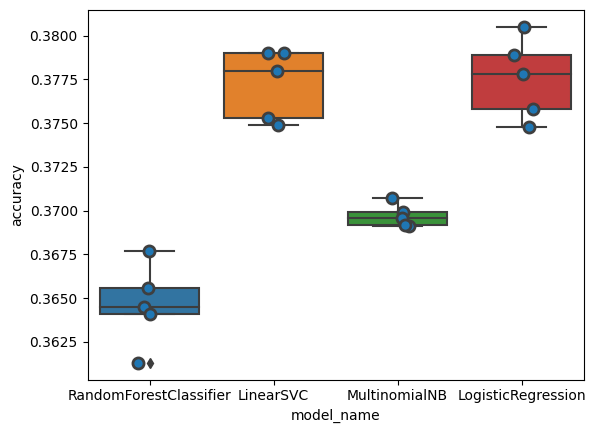

In [216]:
sns.boxplot(x="model_name", y="accuracy", data=cv_df)
sns.stripplot(x="model_name", y="accuracy", data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [217]:
# Compare Text Classification Model performance

mean_accuracy = cv_df.groupby("model_name").accuracy.mean()
std_accuracy = cv_df.groupby("model_name").accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)
acc.columns = ["Mean Accuracy", "Standard deviation"]
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.37724,0.002001
LogisticRegression,0.37756,0.002303
MultinomialNB,0.36970,0.000644
RandomForestClassifier,0.36464,0.002332


In [218]:
# Evaluation of Text Classification Model

X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df.index, test_size=0.25, random_state=42)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: %.4f" % accuracy_score(y_test, y_pred))

Accuracy: 0.3751


In [219]:
# Classification report
print(metrics.classification_report(y_test, y_pred, target_names=df["topic"].unique()))

                         precision    recall  f1-score   support

                 indUnk       0.37      0.90      0.53      4562
                   Arts       0.00      0.00      0.00       564
             Technology       0.00      0.00      0.00       758
              Education       0.00      0.00      0.00       558
                Student       0.40      0.20      0.26      2894
LawEnforcement-Security       0.00      0.00      0.00        28
                    Law       0.00      0.00      0.00       162
          Manufacturing       0.00      0.00      0.00        42
              Marketing       0.00      0.00      0.00        84
             Non-Profit       0.00      0.00      0.00       266
   Communications-Media       0.00      0.00      0.00       372
            Engineering       0.00      0.00      0.00       217
               Internet       0.00      0.00      0.00       277
             Publishing       0.00      0.00      0.00       138
                Science 

c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

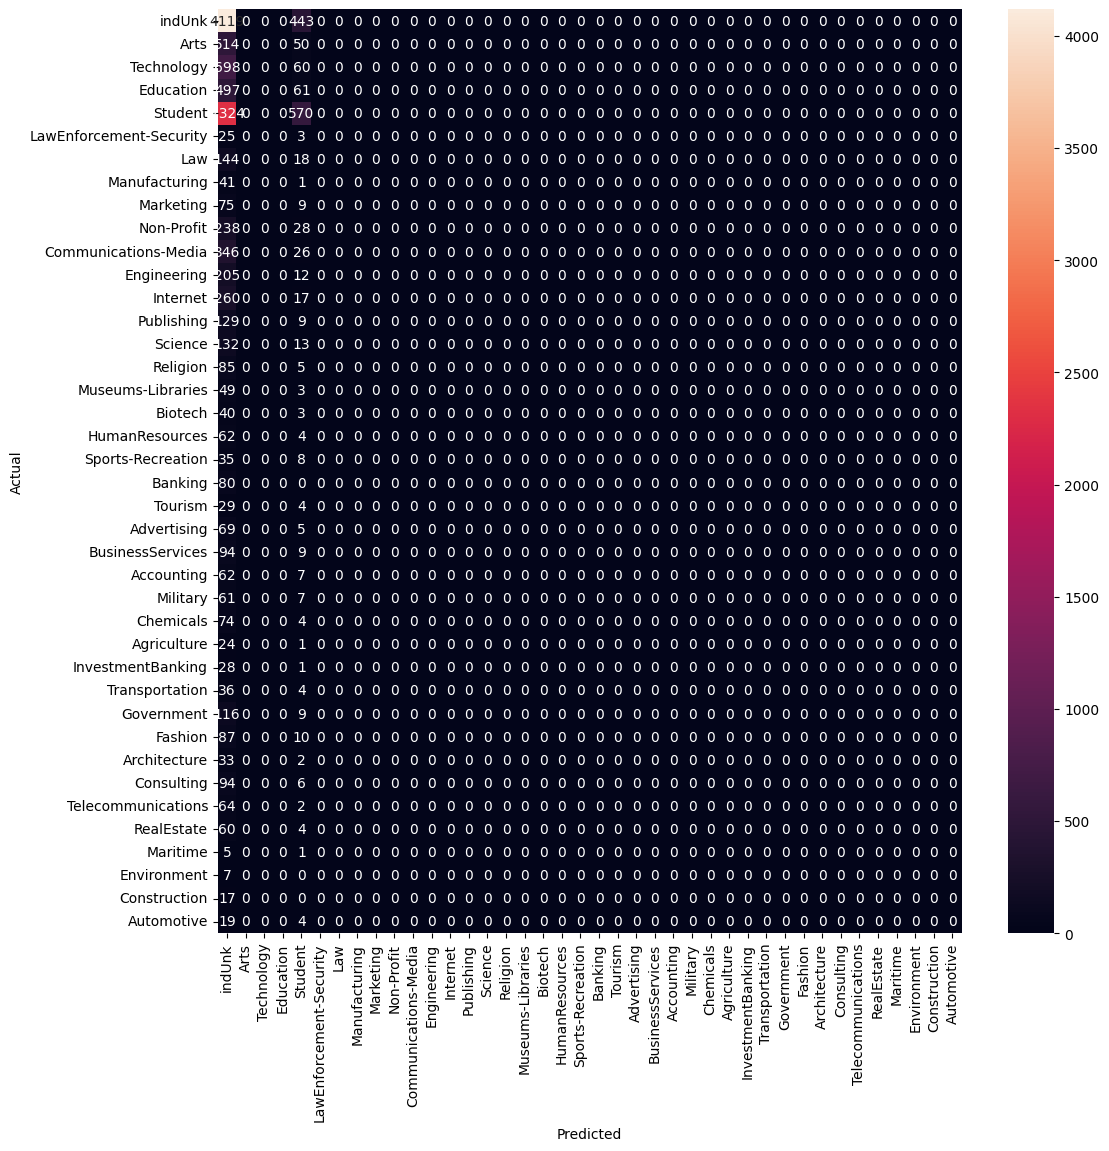

In [220]:
# Now let's plot the confusion matrix to check the miss classified predictions

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=topic_id_df.topic.values, yticklabels=topic_id_df.topic.values)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()